In [4]:
from commonfunctions import *
import math
from skimage.filters import gaussian
from Feature_Extraction import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

Mass Features:
      Area    Perimeter  Circularity  Eccentricity  Solidity    Extent  \
0  24110.0  1078.302727     0.260571      0.845269  0.725131  0.434956   

   Mean_Intensity  Max_Intensity  Std_Intensity    Contrast  Dissimilarity  \
0      209.869751          231.0          6.425  802.879198       4.220155   

   Homogeneity    Energy  Correlation       ASM  
0     0.758535  0.556071     0.969562  0.309215  
Predicted centroid: (588, 535), radius: 154.74172029546526
GT centroid: (492, 590), radius: 87
IOU: 0.223, HIT: True


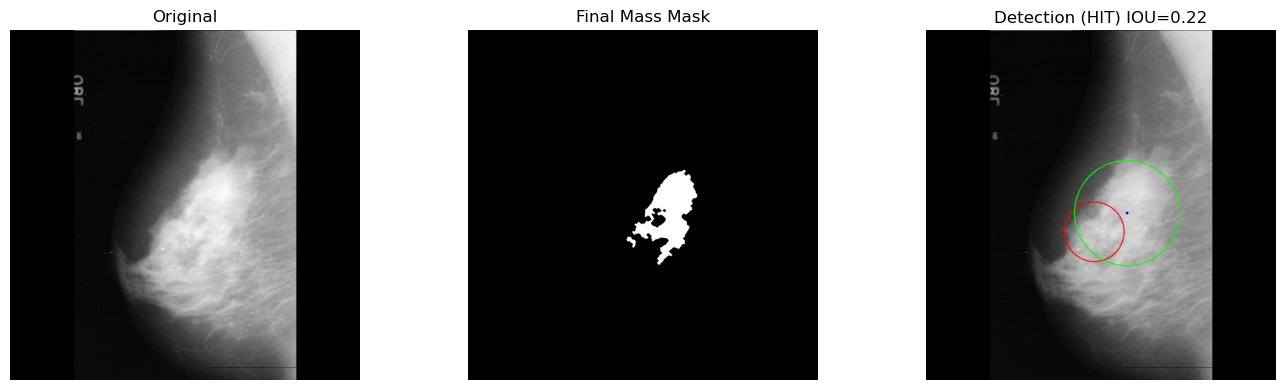

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
import pandas as pd

np.random.seed(42)
random.seed(42)

# ==========================================
# PARAMETERS
# ==========================================
K = 8
BORDER_MARGIN = 50
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# ==========================================
# IOU FUNCTION
# ==========================================
def circle_iou(c1, r1, c2, r2):
    d = np.linalg.norm(np.array(c1) - np.array(c2))
    if d >= r1 + r2:
        return 0.0
    if d <= abs(r1 - r2):
        return (min(r1, r2)**2) / (max(r1, r2)**2)
    a = np.arccos((d**2 + r1**2 - r2**2) / (2*d*r1))
    b = np.arccos((d**2 + r2**2 - r1**2) / (2*d*r2))
    inter = r1**2 * a + r2**2 * b - 0.5 * np.sqrt(
        max(0, (-d+r1+r2)*(d+r1-r2)*(d-r1+r2)*(d+r1+r2))
    )
    return inter / (np.pi*(r1**2 + r2**2) - inter)

# ==========================================
# BREAST MASK
# ==========================================
def extract_breast_mask(img):
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.ones_like(img) * 255
    largest = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [largest], -1, 255, -1)
    return mask

# ==========================================
# PREPROCESSING
# ==========================================
def preprocess_mammogram(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found")
    breast_mask = extract_breast_mask(img)
    img_roi = cv2.bitwise_and(img, img, mask=breast_mask)
    img_eq = cv2.equalizeHist(img_roi)
    img_med = cv2.medianBlur(img_eq, 3)
    data = img_med[breast_mask == 255].reshape(-1, 1).astype(np.float32)
    return img_med, data, img, breast_mask

# ==========================================
# CSO + KMeans++ FUNCTIONS
# ==========================================
def fitness_function(centroids, data):
    distances = np.abs(data - centroids.T)
    min_dist = np.min(distances, axis=1)
    return np.sum(min_dist ** 2)

def assign_clusters(centroids, data):
    distances = np.abs(data - centroids.T)
    return np.argmin(distances, axis=1)

def levy_flight(beta=1.5):
    sigma = (
        math.gamma(1 + beta)
        * math.sin(math.pi * beta / 2)
        / (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))
    ) ** (1 / beta)
    u = np.random.normal(0, sigma)
    v = np.random.normal(0, 1)
    return u / (abs(v) ** (1 / beta))

def kmeans_plus_plus(data, k):
    n = data.shape[0]
    centroids = np.zeros((k, 1))
    centroids[0] = data[np.random.randint(n)]
    for i in range(1, k):
        dists = np.min(np.abs(data - centroids[:i].T), axis=1)
        probs = dists ** 2 / np.sum(dists ** 2)
        centroids[i] = data[np.searchsorted(np.cumsum(probs), np.random.rand())]
    return centroids

def KMpp_CSO(data, k, n_nests=15, pa=0.25, max_gen=50):
    nests = np.zeros((n_nests, k, 1))
    nests[0] = kmeans_plus_plus(data, k)
    min_val, max_val = np.min(data), np.max(data)
    for i in range(1, n_nests):
        nests[i] = np.random.uniform(min_val, max_val, (k, 1))
    fitness = np.array([fitness_function(n, data) for n in nests])
    for _ in range(max_gen):
        for i in range(n_nests):
            step = levy_flight()
            new_nest = nests[i] + step * np.random.randn(k, 1)
            new_nest = np.clip(new_nest, min_val, max_val)
            new_fit = fitness_function(new_nest, data)
            j = random.randint(0, n_nests - 1)
            if new_fit < fitness[j]:
                nests[j] = new_nest
                fitness[j] = new_fit
        abandon = int(pa * n_nests)
        worst = np.argsort(fitness)[-abandon:]
        for idx in worst:
            nests[idx] = np.random.uniform(min_val, max_val, (k, 1))
            fitness[idx] = fitness_function(nests[idx], data)
    best = nests[np.argmin(fitness)]
    labels = assign_clusters(best, data)
    return best, labels

# ==========================================
# SEGMENTATION
# ==========================================
def reconstruct_segmented(labels, centroids, breast_mask, shape):
    segmented = np.zeros(shape, dtype=np.uint8)
    segmented_vals = centroids[labels].astype(np.uint8).flatten()
    segmented[breast_mask == 255] = segmented_vals
    return segmented

# ==========================================
# MASS EXTRACTION
# ==========================================
def extract_mass_mask(segmented_img):
    values = np.unique(segmented_img)
    best_val = None
    best_score = -1
    for v in values:
        if v == 0:
            continue
        mask = np.uint8(segmented_img == v) * 255
        area = cv2.countNonZero(mask)
        if area < 300:
            continue
        M = cv2.moments(mask)
        if M["m00"] == 0:
            continue
        mean_intensity = np.mean(segmented_img[segmented_img == v])
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=cv2.contourArea)
        perim = cv2.arcLength(cnt, True)
        circularity = 4 * np.pi * area / (perim ** 2 + 1e-6)
        score = 0.6 * (mean_intensity / 255.0) + 0.4 * circularity
        if score > best_score:
            best_score = score
            best_val = v
    if best_val is None:
        return np.zeros_like(segmented_img)
    return np.uint8(segmented_img == best_val) * 255

def highest_intensity_component_away_from_border(binary_mask, reference_img, margin=BORDER_MARGIN):
    h, w = binary_mask.shape
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    best_label = None
    best_intensity = -1
    for label in range(1, num_labels):
        x, y, bw, bh, area = stats[label]
        if x < margin or y < margin or x + bw > w - margin or y + bh > h - margin:
            continue
        mean_intensity = np.mean(reference_img[labels == label])
        if mean_intensity > best_intensity:
            best_intensity = mean_intensity
            best_label = label
    if best_label is None:
        return np.zeros_like(binary_mask)
    return np.uint8(labels == best_label) * 255

# ==========================================
# GEOMETRY
# ==========================================
def compute_centroid(mask):
    M = cv2.moments(mask)
    if M["m00"] == 0:
        return None
    return int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])

def compute_radius(mask, centroid):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(contours, key=cv2.contourArea)
    d = np.sqrt((cnt[:, 0, 0] - centroid[0]) ** 2 + (cnt[:, 0, 1] - centroid[1]) ** 2)
    return d.max()

# ==========================================
# LOAD GT FROM CSV
# ==========================================
df = pd.read_csv("train_dataset.csv")
df = df[df["TYPE"] == "MASS"].dropna(subset=["X", "Y", "RADIUS"])

image_name = "mdb121"  # without .pgm
row = df[df["REF"] == image_name].iloc[0]
gt_centroid = (int(row["X"]), int(1024 - row["Y"]))  # invert Y
gt_radius = int(row["RADIUS"])

# ==========================================
# IMAGE PATH
# ==========================================
image_path = f"all-mias/{image_name}.pgm"

# ==========================================
# DETECTION
# ==========================================
img_proc, data, img_raw, breast_mask = preprocess_mammogram(image_path)
centroids, labels = KMpp_CSO(data, K)
segmented = reconstruct_segmented(labels, centroids, breast_mask, img_raw.shape)
mass_mask = extract_mass_mask(segmented)
mass_mask = highest_intensity_component_away_from_border(mass_mask, img_proc, BORDER_MARGIN)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
mass_mask = cv2.erode(mass_mask, kernel, iterations=5)
mass_mask = cv2.dilate(mass_mask, kernel, iterations=2)

pred_centroid = compute_centroid(mass_mask)
pred_radius = compute_radius(mass_mask, pred_centroid)

#print the mass features
print("Mass Features:")
print(extract_mass_features(img_raw,mass_mask))


# ==========================================
# HIT or MISS based on IOU
# ==========================================
iou = circle_iou(pred_centroid, pred_radius, gt_centroid, gt_radius)
hit = iou > 0

print(f"Predicted centroid: {pred_centroid}, radius: {pred_radius}")
print(f"GT centroid: {gt_centroid}, radius: {gt_radius}")
print(f"IOU: {iou:.3f}, HIT: {hit}")



# ==========================================
# VISUALIZATION
# ==========================================
overlay = cv2.cvtColor(img_raw, cv2.COLOR_GRAY2BGR)
cv2.circle(overlay, gt_centroid, gt_radius, (255, 0, 0), 2)          # GT → Blue
cv2.circle(overlay, pred_centroid, int(pred_radius), (0, 255, 0), 2) # Detection → Green
cv2.circle(overlay, pred_centroid, 4, (0, 0, 255), -1)

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_raw, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mass_mask, cmap="gray")
plt.title("Final Mass Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Detection ({'HIT' if hit else 'MISS'}) IOU={iou:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os

# =====================================================
# PARAMETERS
# =====================================================
K = 8
BORDER_MARGIN = 50
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# =====================================================
# IOU and Metrics
# =====================================================
def circle_iou(c1, r1, c2, r2):
    d = np.linalg.norm(np.array(c1) - np.array(c2))
    if d >= r1 + r2:
        return 0.0
    if d <= abs(r1 - r2):
        return (min(r1, r2)**2) / (max(r1, r2)**2)
    a = np.arccos((d**2 + r1**2 - r2**2) / (2*d*r1))
    b = np.arccos((d**2 + r2**2 - r1**2) / (2*d*r2))
    inter = r1**2 * a + r2**2 * b - 0.5 * np.sqrt(
        max(0, (-d+r1+r2)*(d+r1-r2)*(d-r1+r2)*(d+r1+r2))
    )
    return inter / (np.pi*(r1**2 + r2**2) - inter)

# =====================================================
# Load dataset
# =====================================================
df = pd.read_csv("train_dataset.csv")
df = df[df["TYPE"] == "MASS"].dropna(subset=["X", "Y", "RADIUS"])

hits = 0
misses = 0
ious = []

# =====================================================
# MAIN LOOP
# =====================================================
for _, row in df.iterrows():
    image_path = f"all-mias/{row['REF']}.pgm"

    try:
        img_proc, data, img_raw, breast_mask = preprocess_mammogram(image_path)
    except:
        misses += 1
        continue

    # -------------------------
    # Run detection
    # -------------------------
    centroids, labels = KMpp_CSO(data, K)
    segmented = reconstruct_segmented(labels, centroids, breast_mask, img_raw.shape)

    mass_mask = extract_mass_mask(segmented)
    mass_mask = highest_intensity_component_away_from_border(
        mass_mask, img_proc, BORDER_MARGIN
    )

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mass_mask = cv2.erode(mass_mask, kernel, iterations=5)
    mass_mask = cv2.dilate(mass_mask, kernel, iterations=2)

    pred_centroid = compute_centroid(mass_mask)
    if pred_centroid is None:
        misses += 1
        continue
    pred_radius = compute_radius(mass_mask, pred_centroid)

    # ---- Ground truth (Y inverted) ----
    gt_centroid = (int(row["X"]), int(1024 - row["Y"]))
    gt_radius = int(row["RADIUS"])

    # ---- IOU-based hit/miss ----
    iou = circle_iou(pred_centroid, pred_radius, gt_centroid, gt_radius)
    hit = iou > 0

    hits += int(hit)
    misses += int(not hit)
    ious.append(iou)

    # ---- Save image ----
    vis = cv2.cvtColor(img_raw, cv2.COLOR_GRAY2BGR)
    cv2.circle(vis, gt_centroid, gt_radius, (255, 0, 0), 2)          # GT → Blue
    cv2.circle(vis, pred_centroid, int(pred_radius), (0, 255, 0), 2) # Detection → Green
    out_name = f"{row['REF']}_{'HIT' if hit else 'MISS'}_IoU_{iou:.2f}.png"
    cv2.imwrite(os.path.join(RESULTS_DIR, out_name), vis)

# =====================================================
# FINAL REPORT
# =====================================================
total = hits + misses
print("===================================")
print(f"Total MASS samples: {total}")
print(f"Hits: {hits}")
print(f"Misses: {misses}")
print(f"Hit Rate: {hits / total:.2%}")
print(f"Mean IoU: {np.mean(ious):.3f}")
print("===================================")
